In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [7]:
import joblib
from datetime import datetime


In [9]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [11]:
os.makedirs("outputs/plots", exist_ok=True)
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/data", exist_ok=True)


In [13]:
print("Imports done. Output folders created.")

Imports done. Output folders created.


In [17]:
DATA_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"{DATA_PATH} not found. Download the Telco dataset and place it in this folder.\n"
        "Kaggle filename: WA_Fn-UseC_-Telco-Customer-Churn.csv"
    )

df = pd.read_csv(DATA_PATH)
print("Loaded dataset with shape:", df.shape)
display(df.head())


Loaded dataset with shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nMissing values per column:")
display(df.isna().sum())

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null

None


Missing values per column:


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [21]:
df_clean = df.copy()

In [23]:
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
num_missing_totalcharges = df_clean['TotalCharges'].isna().sum()
print(f"TotalCharges missing after conversion: {num_missing_totalcharges}")

TotalCharges missing after conversion: 11


In [25]:
if num_missing_totalcharges > 0:
    df_clean = df_clean[~df_clean['TotalCharges'].isna()].copy()
    df_clean.reset_index(drop=True, inplace=True)
    print("Dropped rows with missing TotalCharges. New shape:", df_clean.shape)

Dropped rows with missing TotalCharges. New shape: (7032, 21)


In [27]:
if 'customerID' in df_clean.columns:
    df_clean.drop('customerID', axis=1, inplace=True)


In [29]:
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

In [31]:
print("\nAfter cleaning:")
display(df_clean.head())
print(df_clean.dtypes.value_counts())



After cleaning:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


object     15
int64       3
float64     2
Name: count, dtype: int64


In [33]:
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
num_cols = df_clean.select_dtypes(include=[np.number]).columns.drop('Churn').tolist()
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [35]:
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
print("After get_dummies shape:", df_encoded.shape)

After get_dummies shape: (7032, 31)


In [37]:
df_clean.to_csv("outputs/data/telco_cleaned.csv", index=False)

In [41]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Churn rate (overall):", round(y.mean(), 4))

Train shape: (5625, 30) Test shape: (1407, 30)
Churn rate (overall): 0.2658


In [45]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
pipe_lr.fit(X_train, y_train)
print("Trained Logistic Regression (pipeline).")

rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
print("Trained Random Forest.")


Trained Logistic Regression (pipeline).
Trained Random Forest.


In [49]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"--- {model_name} ---")
    print("Accuracy:", round(acc, 4))
    print("F1-score:", round(f1, 4))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    return dict(accuracy=acc, f1=f1, report=classification_report(y_test, y_pred, digits=4, output_dict=True)), cm


In [51]:
metrics_lr, cm_lr = evaluate_model(pipe_lr, X_test, y_test, "Logistic Regression")
metrics_rf, cm_rf = evaluate_model(rf, X_test, y_test, "Random Forest")


--- Logistic Regression ---
Accuracy: 0.8038
F1-score: 0.6091
Classification Report:
              precision    recall  f1-score   support

           0     0.8521    0.8867    0.8691      1033
           1     0.6476    0.5749    0.6091       374

    accuracy                         0.8038      1407
   macro avg     0.7498    0.7308    0.7391      1407
weighted avg     0.7977    0.8038    0.8000      1407

--- Random Forest ---
Accuracy: 0.7868
F1-score: 0.5588
Classification Report:
              precision    recall  f1-score   support

           0     0.8329    0.8877    0.8594      1033
           1     0.6209    0.5080    0.5588       374

    accuracy                         0.7868      1407
   macro avg     0.7269    0.6979    0.7091      1407
weighted avg     0.7765    0.7868    0.7795      1407



In [53]:
metrics_df = pd.DataFrame({
    'model': ['LogisticRegression', 'RandomForest'],
    'accuracy': [metrics_lr['accuracy'], metrics_rf['accuracy']],
    'f1': [metrics_lr['f1'], metrics_rf['f1']],
    'timestamp': datetime.now().isoformat()
})
metrics_df.to_csv("outputs/data/metrics_summary.csv", index=False)
print("Saved metrics_summary.csv")


Saved metrics_summary.csv


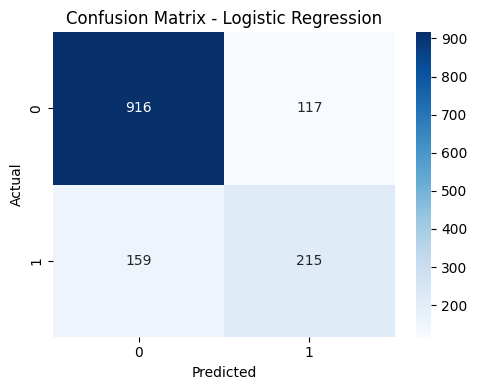

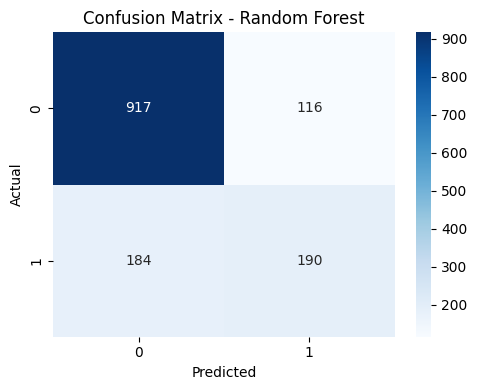

In [55]:
def plot_confusion(cm, title, filename):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()

plot_confusion(cm_lr, "Confusion Matrix - Logistic Regression", "outputs/plots/cm_logistic.png")
plot_confusion(cm_rf, "Confusion Matrix - Random Forest", "outputs/plots/cm_rf.png")

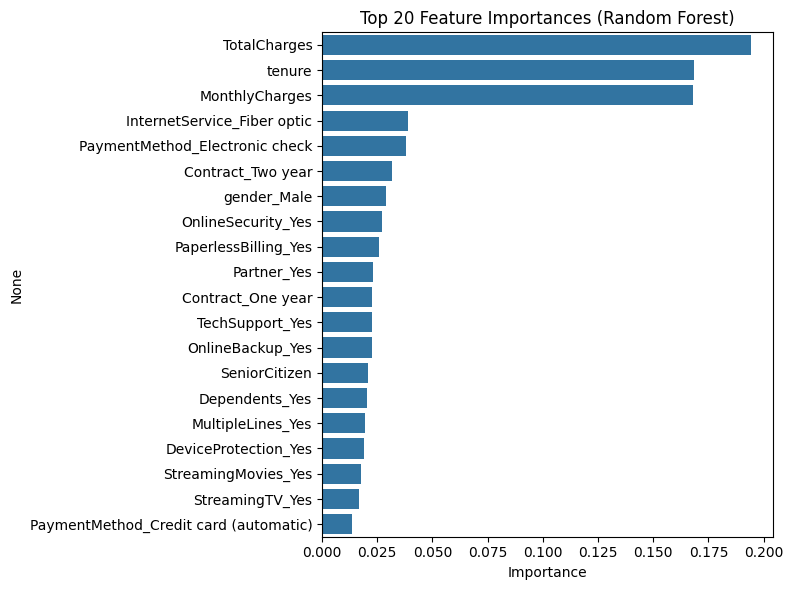

In [57]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)
top_n = 20
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp_sorted.values[:top_n], y=feat_imp_sorted.index[:top_n])
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("outputs/plots/feature_importances_rf_top20.png", dpi=150)
plt.show()

In [59]:
feat_imp_sorted.to_csv("outputs/data/feature_importances_full.csv", header=['importance'])

In [61]:
print("Top 10 features (RF):")
display(feat_imp_sorted.head(10))


Top 10 features (RF):


TotalCharges                      0.194313
tenure                            0.168529
MonthlyCharges                    0.167972
InternetService_Fiber optic       0.038913
PaymentMethod_Electronic check    0.037898
Contract_Two year                 0.031862
gender_Male                       0.028939
OnlineSecurity_Yes                0.027288
PaperlessBilling_Yes              0.025595
Partner_Yes                       0.023280
dtype: float64

In [63]:
df_insights = pd.read_csv("outputs/data/telco_cleaned.csv")

Churn rate by Contract (highest to lowest):


Contract
Month-to-month    0.427097
One year          0.112772
Two year          0.028487
Name: Churn, dtype: float64

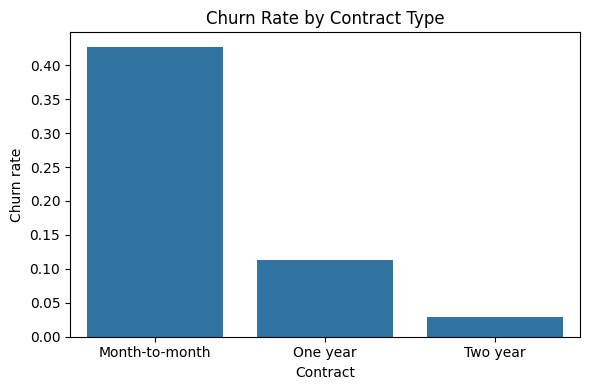

In [67]:
churn_by_contract = df_insights.groupby('Contract')['Churn'].mean().sort_values(ascending=False)
print("Churn rate by Contract (highest to lowest):")
display(churn_by_contract)

plt.figure(figsize=(6,4))
sns.barplot(x=churn_by_contract.index, y=churn_by_contract.values)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn rate")
plt.tight_layout()
plt.savefig("outputs/plots/churn_by_contract.png", dpi=150)
plt.show()

Churn rate by InternetService:


InternetService
Fiber optic    0.418928
DSL            0.189983
No             0.074342
Name: Churn, dtype: float64

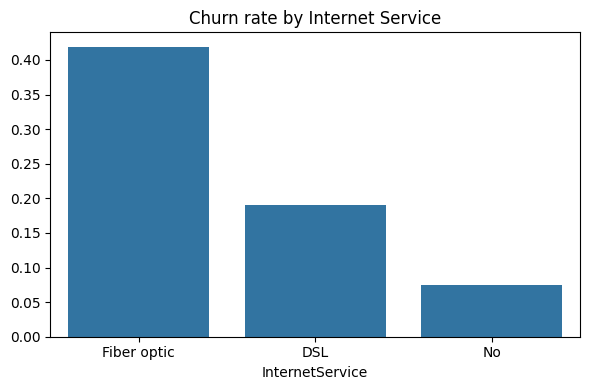

In [69]:
if 'InternetService' in df_insights.columns:
    churn_by_internet = df_insights.groupby('InternetService')['Churn'].mean().sort_values(ascending=False)
    print("Churn rate by InternetService:")
    display(churn_by_internet)
    plt.figure(figsize=(6,4))
    sns.barplot(x=churn_by_internet.index, y=churn_by_internet.values)
    plt.title("Churn rate by Internet Service")
    plt.tight_layout()
    plt.savefig("outputs/plots/churn_by_internet.png", dpi=150)
    plt.show()

Churn rate by tenure group:


tenure_group
0-12     0.476782
13-24    0.287109
25-48    0.203890
49-72    0.095132
Name: Churn, dtype: float64

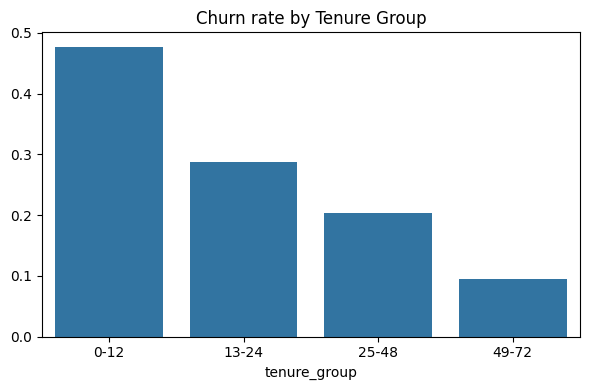

In [71]:
bins = [0, 12, 24, 48, 72]
labels = ['0-12','13-24','25-48','49-72']
df_insights['tenure_group'] = pd.cut(df_insights['tenure'], bins=bins, labels=labels, include_lowest=True)
churn_by_tenure = df_insights.groupby('tenure_group')['Churn'].mean().sort_values(ascending=False)
print("Churn rate by tenure group:")
display(churn_by_tenure)
plt.figure(figsize=(6,4))
sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure.values)
plt.title("Churn rate by Tenure Group")
plt.tight_layout()
plt.savefig("outputs/plots/churn_by_tenure.png", dpi=150)
plt.show()

In [73]:
corr = df_insights[num_cols + ['Churn']].corr()['Churn'].sort_values(ascending=False)
print("Numeric features correlation with Churn (top positive):")
display(corr.head(10))
corr.to_csv("outputs/data/churn_correlation_numeric.csv")

Numeric features correlation with Churn (top positive):


Churn             1.000000
MonthlyCharges    0.192858
SeniorCitizen     0.150541
TotalCharges     -0.199484
tenure           -0.354049
Name: Churn, dtype: float64

In [75]:
joblib.dump(pipe_lr, "outputs/models/logistic_pipeline.joblib")
joblib.dump(rf, "outputs/models/random_forest.joblib")
print("Saved models to outputs/models/")

Saved models to outputs/models/


In [77]:
X.to_csv("outputs/data/X_encoded.csv", index=False)
y.to_csv("outputs/data/y.csv", index=False)
print("Saved X_encoded.csv and y.csv")

Saved X_encoded.csv and y.csv
